In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.inspection import permutation_importance
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
DATA_FOLDER = r"/home/check/DATA/university/yr3, hk1/DS102 - ML for Statistic/Đồ án/goodread/DS102/DATA/gold/v1/"
MODELS_FOLDER = r"/home/check/DATA/university/yr3, hk1/DS102 - ML for Statistic/Đồ án/goodread/DS102/models/tradition"
PLOTS_FOLDER = os.path.join(MODELS_FOLDER, "plots")
os.makedirs(PLOTS_FOLDER, exist_ok=True)

TRAIN_FILE = DATA_FOLDER + "train_1.csv"
TEST_FILE = DATA_FOLDER + "test_1.csv"

target_cols = ['Commercial_success', 'Popular_success', 'Critical_success']
figsize = (15,10)

In [25]:
test_df = pd.read_csv(os.path.join(DATA_FOLDER, TEST_FILE))
X_test = test_df.drop(columns=target_cols)
y_test = test_df[target_cols]

In [ ]:
model_files = {
    "logistic": "processed_logistic.joblib",
    "rf": "processed_rf.joblib",
    "svm": "processed_svm.joblib",
    "xgb": "processed_xgb.joblib"
}

models = {}
print("Đang load 4 model đã train...")
for name, file in model_files.items():
    path = os.path.join(MODELS_FOLDER, file)
    models[name] = joblib.load(path)
    print(f"   → Loaded {name.upper()}")

In [34]:
feature_importance = {}
results = {}  # Để lưu F1-macro cho bảng tổng kết

for name, model in models.items():
    print(f"\n{'-'*30} {name.upper()} {'-'*30}")
    
    if name == "xgb":
        y_pred = model.predict(X_test) + 1
    else:
        y_pred = model.predict(X_test)
    
    # Classification Report đầy đủ
    for i, col in enumerate(target_cols):
        print(f"\n{col.upper()}")
        print(classification_report(
            y_test.iloc[:, i],
            y_pred[:, i],
            target_names=[f'Class {c}' for c in range(1, 6)],
            digits=3
        ))
    
    # F1-macro scores
    f1_scores = {}
    for i, col in enumerate(target_cols):
        f1 = f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro')
        f1_scores[col] = round(f1, 4)
    avg_f1 = np.mean(list(f1_scores.values()))
    f1_scores['avg'] = round(avg_f1, 4)
    results[name] = f1_scores
    
    print(f"\nF1-macro: {f1_scores} | Avg F1: {avg_f1:.4f}")


------------------------------ LOGISTIC ------------------------------

COMMERCIAL_SUCCESS
              precision    recall  f1-score   support

     Class 1      0.819     0.868     0.843        68
     Class 2      0.672     0.703     0.687        64
     Class 3      0.415     0.319     0.361        69
     Class 4      0.636     0.817     0.715       120
     Class 5      0.958     0.708     0.814        96

    accuracy                          0.700       417
   macro avg      0.700     0.683     0.684       417
weighted avg      0.709     0.700     0.696       417


POPULAR_SUCCESS
              precision    recall  f1-score   support

     Class 1      0.764     0.592     0.667        71
     Class 2      0.590     0.790     0.675       100
     Class 3      0.534     0.540     0.537        87
     Class 4      0.614     0.510     0.557       100
     Class 5      0.649     0.627     0.638        59

    accuracy                          0.614       417
   macro avg      0.63

In [35]:
print("\n" + "="*60)
print("TỔNG KẾT F1-MACRO & ACCURACY")
print("="*60)
print(f"{'Model':<12} {'Commercial':<12} {'Popular':<10} {'Critical':<10} {'Avg F1':<8} {'Accuracy'}")
print("-"*70)
for name, scores in results.items():
    acc = np.mean([ (models[name].predict(X_test)[:, i] == y_test.iloc[:, i]).mean() for i in range(3) ])
    if name == "xgb":
        acc = np.mean([ ((models[name].predict(X_test) + 1)[:, i] == y_test.iloc[:, i]).mean() for i in range(3) ])
    print(f"{name.upper():<12} {scores['Commercial_success']:<12.3f} {scores['Popular_success']:<10.3f} "
          f"{scores['Critical_success']:<10.3f} {scores['avg']:<8.3f} {acc:.3f}")


TỔNG KẾT F1-MACRO & ACCURACY
Model        Commercial   Popular    Critical   Avg F1   Accuracy
----------------------------------------------------------------------
LOGISTIC     0.684        0.615      0.681      0.660    0.672
RF           0.805        0.554      0.604      0.655    0.675
SVM          0.701        0.595      0.653      0.650    0.650
XGB          0.907        0.774      0.744      0.809    0.812


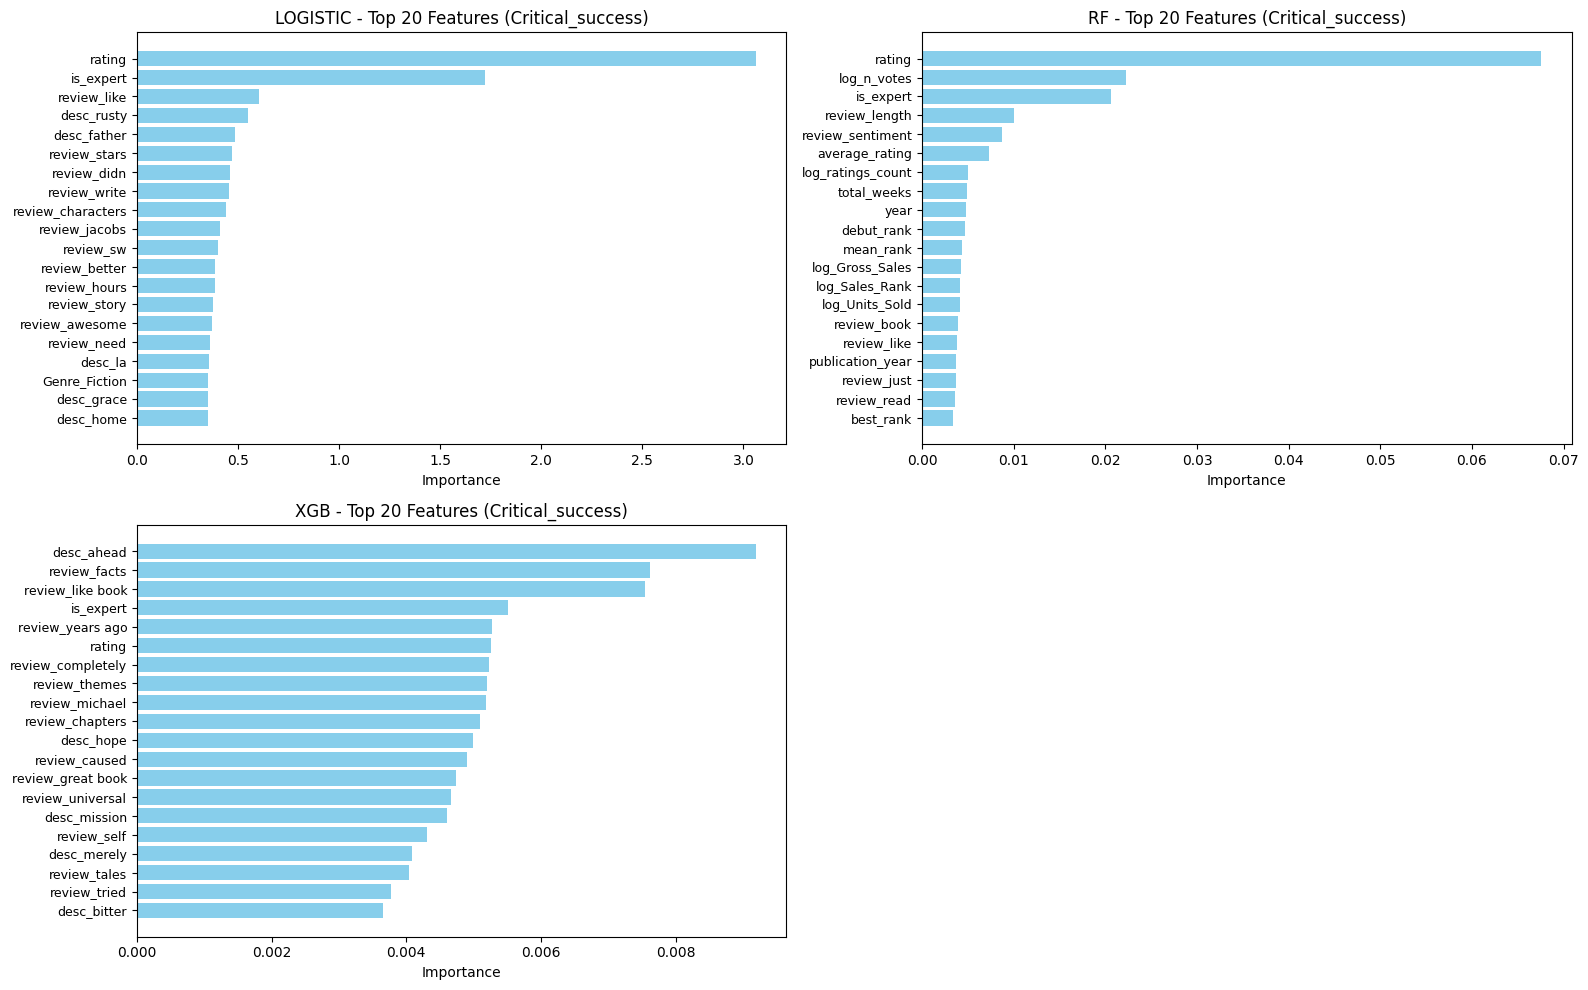

In [30]:
plt.figure(figsize=(16, 10))
for idx, (name, top20) in enumerate(feature_importance.items()):
    plt.subplot(2, 2, idx+1)
    feats, scores = zip(*top20)
    y_pos = np.arange(len(feats))
    plt.barh(y_pos, scores, color='skyblue')
    plt.yticks(y_pos, feats, fontsize=9)
    plt.gca().invert_yaxis()
    plt.title(f'{name.upper()} - Top 20 Features (Critical_success)')
    plt.xlabel('Importance')

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, 'final_feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

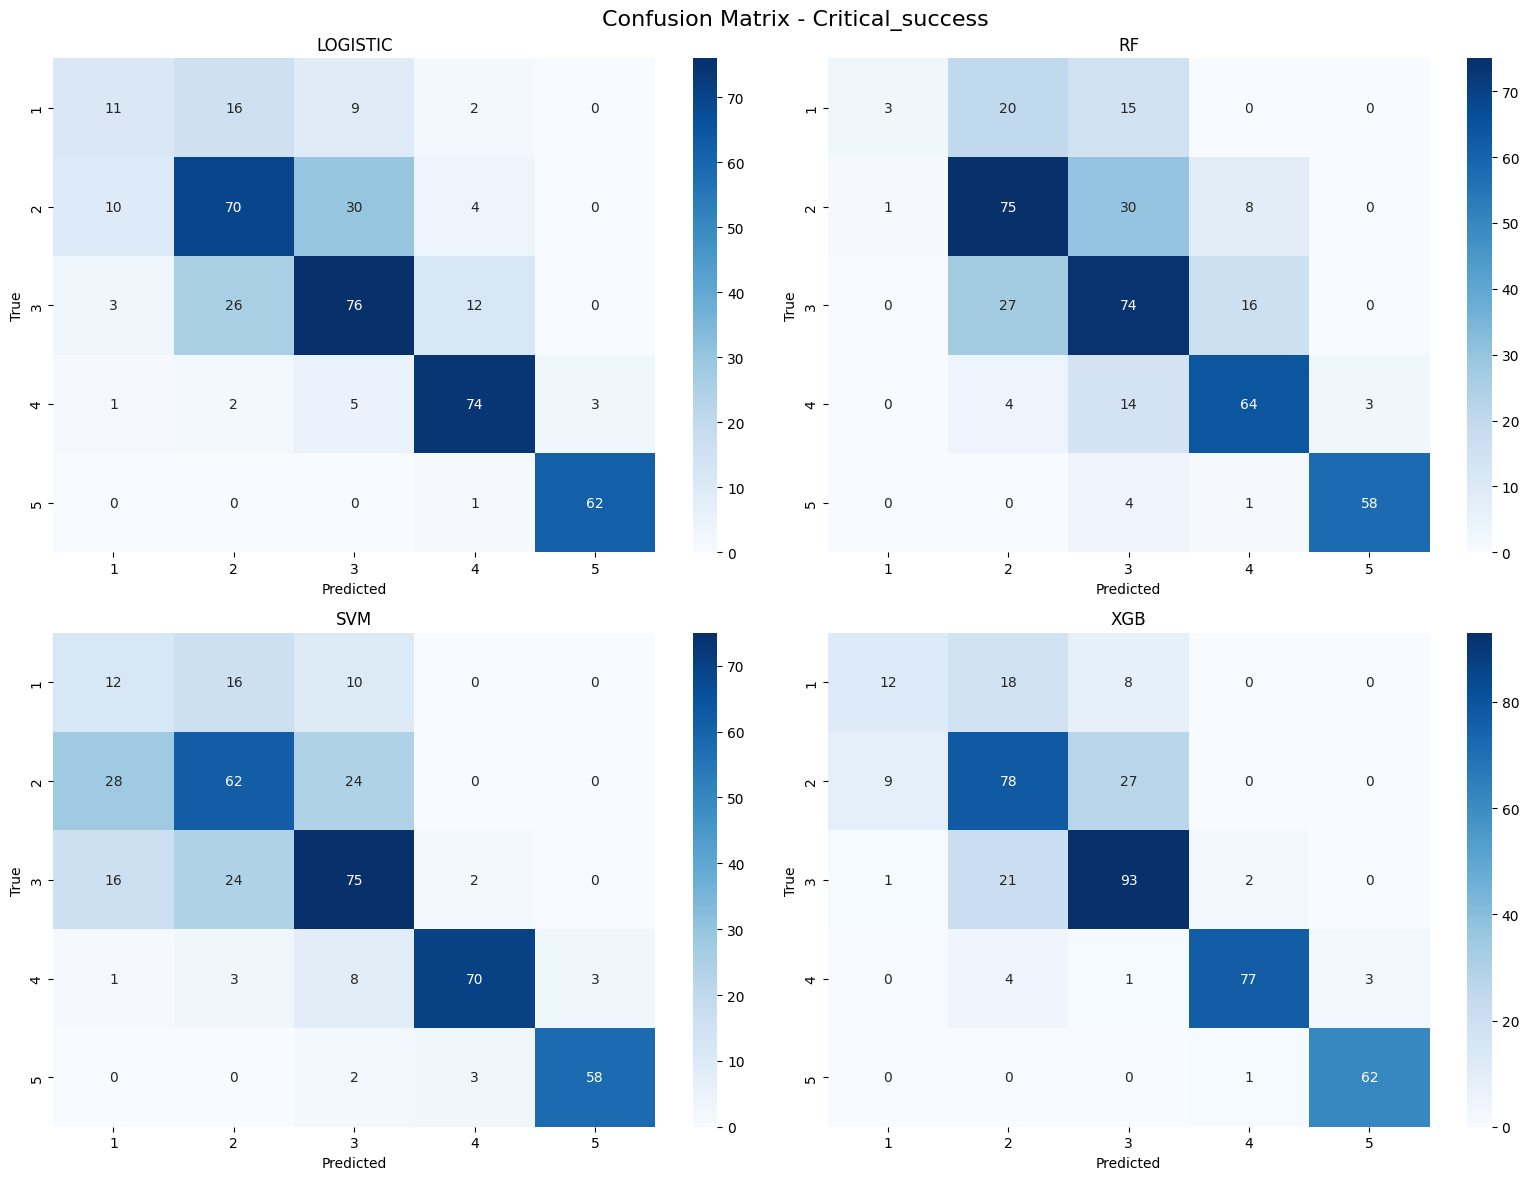

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Confusion Matrix - Critical_success', fontsize=16)

for idx, (name, model) in enumerate(loaded_models.items()):
    row, col = idx // 2, idx % 2
    if name == "xgb":
        y_pred_crit = model.predict(X_test)[:, 2] + 1
    else:
        y_pred_crit = model.predict(X_test)[:, 2]
    
    cm = confusion_matrix(y_test['Critical_success'], y_pred_crit)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=range(1,6), yticklabels=range(1,6))
    axes[row, col].set_title(f'{name.upper()}')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('True')

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, 'confusion_matrix_critical_quick.png'), dpi=300, bbox_inches='tight')
plt.show()